# Tool-Tip Tracking — Lucas-Kanade Optical Flow

Track a single point (e.g. a surgical tool tip) across every frame of a video using pyramidal Lucas-Kanade optical flow, then save the trajectory to a CSV.

## 1 — Imports

In [1]:
import os
import cv2
import csv
import numpy as np
import matplotlib.pyplot as plt

# Repo root (two levels up from analysis/tutorials/)
ROOT = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
print(f"ROOT: {ROOT}")

%matplotlib inline

ROOT: /home/navlab/sukeerth/Tree/TreeHacks/treehacks-2026


## 2 — Read Video Frames

In [2]:
def read_video_frames(video_path):
    """Open a video file and return all frames as a list of BGR numpy arrays."""
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise FileNotFoundError(f"Cannot open video: {video_path}")

    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    print(f"Video: {total} frames, {fps:.1f} fps")

    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()

    print(f"Loaded {len(frames)} frames")
    return frames

## 3 — Initialize Tracking Point

In [3]:
def init_tracking_point(x, y):
    """Wrap (x, y) as a numpy float32 array shaped for OpenCV's LK tracker."""
    return np.array([[x, y]], dtype=np.float32)

## 4 — Track Point with Lucas-Kanade Optical Flow

In [4]:
def track_point_lk(frames, init_pt):
    """Track a single point across frames using pyramidal Lucas-Kanade optical flow.

    Returns a list of (frame_idx, x, y) tuples.
    """
    lk_params = dict(
        winSize=(15, 15),
        maxLevel=3,
        criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01),
    )

    prev_pts  = init_pt.copy()
    prev_gray = cv2.cvtColor(frames[0], cv2.COLOR_BGR2GRAY)

    tracked_positions = [(0, float(prev_pts[0][0]), float(prev_pts[0][1]))]

    for i in range(1, len(frames)):
        frame_gray = cv2.cvtColor(frames[i], cv2.COLOR_BGR2GRAY)

        next_pts, status, err = cv2.calcOpticalFlowPyrLK(
            prev_gray, frame_gray, prev_pts, None, **lk_params
        )

        if status[0][0] == 0:
            # Lost track — keep previous position
            next_pts = prev_pts.copy()

        x, y = next_pts[0]
        tracked_positions.append((i, float(x), float(y)))

        prev_gray = frame_gray.copy()
        prev_pts  = next_pts.copy()

        if (i % 100) == 0:
            print(f"  Tracked {i}/{len(frames)} frames ...")

    print(f"Tracking complete: {len(tracked_positions)} positions")
    return tracked_positions

## 5 — Save Tracked Positions to CSV

In [5]:
def save_to_csv(tracked_positions, out_csv):
    """Write tracked (frame_idx, x, y) positions to a CSV file."""
    os.makedirs(os.path.dirname(out_csv), exist_ok=True)
    with open(out_csv, mode="w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["frame_idx", "x", "y"])
        writer.writerows(tracked_positions)
    print(f"Saved {len(tracked_positions)} rows to {out_csv}")

## 6 — Visualize Tracking Results

In [ ]:
def visualize_tracking(frames, tracked_positions, sample_every=50):
    """Show a few sampled frames with the tracked point drawn as a red circle."""
    indices = list(range(0, len(tracked_positions), sample_every))
    n = len(indices)
    fig, axes = plt.subplots(1, min(n, 8), figsize=(4 * min(n, 8), 4))
    if min(n, 8) == 1:
        axes = [axes]

    for ax, idx in zip(axes, indices[:8]):
        frame_idx, x, y = tracked_positions[idx]
        rgb = cv2.cvtColor(frames[frame_idx], cv2.COLOR_BGR2RGB).copy()
        cv2.circle(rgb, (int(x), int(y)), 8, (255, 0, 0), -1)
        cv2.circle(rgb, (int(x), int(y)), 10, (255, 255, 255), 2)
        ax.imshow(rgb)
        ax.set_title(f"Frame {frame_idx}", fontsize=9)
        ax.axis("off")

    plt.tight_layout()
    plt.show()


def plot_trajectory(tracked_positions):
    """Plot x and y coordinates over time."""
    idxs = [p[0] for p in tracked_positions]
    xs   = [p[1] for p in tracked_positions]
    ys   = [p[2] for p in tracked_positions]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
    ax1.plot(idxs, xs, linewidth=0.8)
    ax1.set_ylabel("x (px)")
    ax1.set_title("Tracked Point Trajectory")
    ax1.grid(True, alpha=0.3)

    ax2.plot(idxs, ys, linewidth=0.8, color="tab:orange")
    ax2.set_ylabel("y (px)")
    ax2.set_xlabel("Frame Index")
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

## 7 — Run Pipeline (set hyperparameters below and re-run)

Video: 1638 frames, 24.0 fps
Loaded 1636 frames
  Tracked 100/1636 frames ...
  Tracked 200/1636 frames ...
  Tracked 300/1636 frames ...
  Tracked 400/1636 frames ...
  Tracked 500/1636 frames ...
  Tracked 600/1636 frames ...
  Tracked 700/1636 frames ...
  Tracked 800/1636 frames ...
  Tracked 900/1636 frames ...
  Tracked 1000/1636 frames ...
  Tracked 1100/1636 frames ...
  Tracked 1200/1636 frames ...
  Tracked 1300/1636 frames ...
  Tracked 1400/1636 frames ...
  Tracked 1500/1636 frames ...
  Tracked 1600/1636 frames ...
Tracking complete: 1636 positions
Saved 1636 rows to /home/navlab/sukeerth/Tree/TreeHacks/treehacks-2026/analysis/outputs/tracking/tracked_output.csv


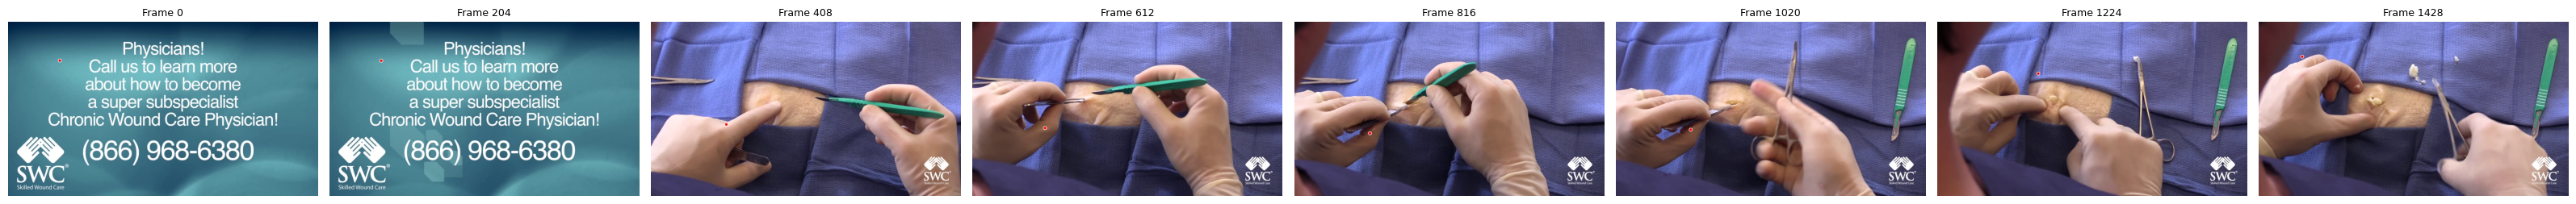

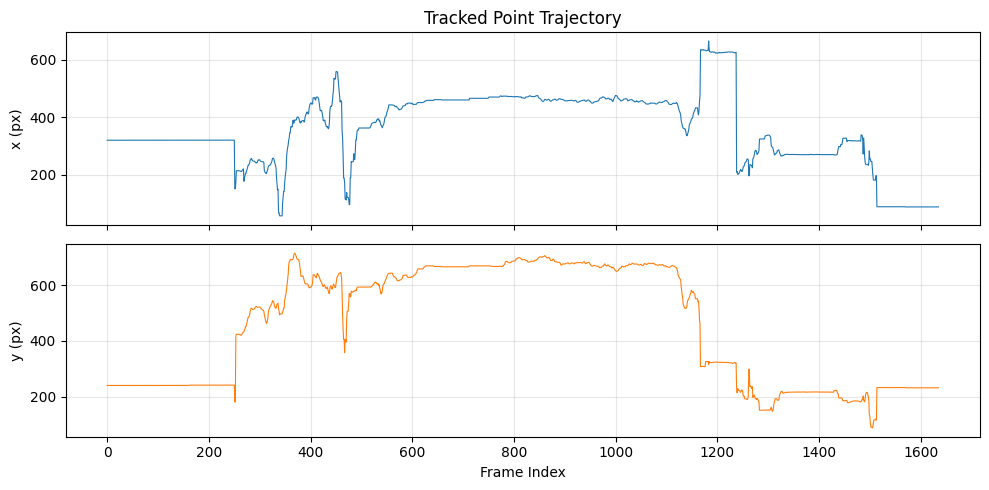

In [7]:
# ---- Hyperparameters — change these per run -------------------------
video_path  = "analysis/data/sam3/surgery_video.mp4"       # input video (relative to ROOT)
output_path = "analysis/outputs/tracking/tracked_output.csv"  # output CSV  (relative to ROOT)
init_x      = 320.0                                        # initial x coordinate of the point
init_y      = 240.0                                        # initial y coordinate of the point
# ---------------------------------------------------------------------

# Resolve to absolute paths
video_path_abs  = os.path.join(ROOT, video_path)
output_path_abs = os.path.join(ROOT, output_path)

# 1. Read frames
frames = read_video_frames(video_path_abs)

# 2. Initialize tracking point
init_pt = init_tracking_point(init_x, init_y)

# 3. Track across all frames
tracked_positions = track_point_lk(frames, init_pt)

# 4. Save to CSV
save_to_csv(tracked_positions, output_path_abs)

# 5. Visualize
visualize_tracking(frames, tracked_positions, sample_every=max(1, len(frames) // 8))
plot_trajectory(tracked_positions)